## 20190318

【第一个可用的程序】

测试集上表现OK，test loss 0.2多

**主要修改：**
1. 将test输出结果与编号对应上
2. 改为one-hot编码

多次调参修改模型后，最好的是参数是：  
conv2D 10层，全连接2层。数据增强：旋转30；缩放0.2；左右上下平移0.2；水平垂直翻转  
test loss: 0.23535  

![](https://ww1.sinaimg.cn/large/007i4MEmgy1g17u2fi4b1j309b068weq.jpg)

## Part 1 - Preprocessing ##

We've got the data, but we can't exactly just stuff raw images right through our convolutional neural network. First, we need all of the images to be the same size, and then we also will probably want to just grayscale them. Also, the labels of "cat" and "dog" are not useful, we want them to be one-hot arrays. 


In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel Bühler for this suggestion
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline


Using TensorFlow backend.


In [2]:
TRAIN_DIR = './data/train'
TEST_DIR = './data/test'
IMG_SIZE = 128
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

label -> one-hot

In [3]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': 
        return [1,0]
    elif word_label == 'dog': 
        return [0,1]

Now, we can build another function to fully process the training images and their labels into arrays:

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img), label])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [5]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    #shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

Now, we can run the training:

In [6]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')

100%|██████████| 25000/25000 [00:25<00:00, 978.77it/s] 


In [7]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train_data, test_size = 0.25)

In [8]:
X_train = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y_train = np.array([i[1] for i in train])

X_val = np.array([i[0] for i in val]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y_val = np.array([i[1] for i in val])

## Convolutional Neural Network ##

Next, we're ready to define our neural network:

In [1]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
from keras import backend
backend.set_image_dim_ordering('tf')  # th通道最前，tf通道最后

In [8]:
optimizer = RMSprop(lr=1e-4)
objective = 'categorical_crossentropy'
IMG_SIZE = 128

def catdog():
    
    model = Sequential()

    model.add(Conv2D(64, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1), activation='relu'))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    '''
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    '''    

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(2, activation='softmax'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()

In [6]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 32, 32, 256)       295168    
__________

In [13]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
        shear_range=0.3,    #错切变换，效果就是让所有点的x坐标(或者y坐标)保持不变，而对应的y坐标(或者x坐标)则按比例发生平移
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images


#datagen = ImageDataGenerator()
datagen.fit(X_train)

In [14]:
epochs = 100
batch_size = 64

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=5e-8)

early_stopping = EarlyStopping(monitor='val_loss', patience=8, min_delta=0.0002, verbose=1, mode='auto')     
filepath="./weights/weights.best.hdf5"
if not os.path.exists('./weights'):
        os.mkdir('./weights')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
       
        
def run_catdog():
    
    model_his = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val), shuffle=True, 
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction, early_stopping, checkpoint])
    '''
    model_his = model.fit(X_train, np.array(Y_train), batch_size=batch_size, epochs=epochs,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[learning_rate_reduction, early_stopping, checkpoint])

    '''
    return model_his

history = run_catdog()

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
292/292 [==============================] - 147s 503ms/step - loss: 0.7007 - acc: 0.5072 - val_loss: 0.6902 - val_acc: 0.5099

Epoch 00001: val_loss improved from inf to 0.69025, saving model to ./weights/weights.best.hdf5
Epoch 2/100
292/292 [==============================] - 140s 480ms/step - loss: 0.7025 - acc: 0.5530 - val_loss: 0.6697 - val_acc: 0.5984

Epoch 00002: val_loss improved from 0.69025 to 0.66969, saving model to ./weights/weights.best.hdf5
Epoch 3/100
292/292 [==============================] - 136s 467ms/step - loss: 0.6748 - acc: 0.5959 - val_loss: 0.6434 - val_acc: 0.6282

Epoch 00003: val_loss improved from 0.66969 to 0.64336, saving model to ./weights/weights.best.hdf5
Epoch 4/100
292/292 [==============================] - 136s 466ms/step - loss: 0.6541 - acc: 0.6320 - val_loss: 0.6196 - val_acc: 0.6680

Epoch 00004: val_loss improved from 0.64336 to 0.61957, saving model to ./weights/weights.best.hdf5
Epoc

292/292 [==============================] - 136s 465ms/step - loss: 0.1976 - acc: 0.9230 - val_loss: 0.1707 - val_acc: 0.9451

Epoch 00037: val_loss did not improve from 0.15959
Epoch 38/100
292/292 [==============================] - 136s 465ms/step - loss: 0.1980 - acc: 0.9283 - val_loss: 0.1630 - val_acc: 0.9422

Epoch 00038: val_loss did not improve from 0.15959
Epoch 39/100
292/292 [==============================] - 136s 466ms/step - loss: 0.2074 - acc: 0.9252 - val_loss: 0.1520 - val_acc: 0.9443

Epoch 00039: val_loss improved from 0.15959 to 0.15196, saving model to ./weights/weights.best.hdf5
Epoch 40/100
292/292 [==============================] - 136s 465ms/step - loss: 0.2204 - acc: 0.9258 - val_loss: 0.1841 - val_acc: 0.9382

Epoch 00040: val_loss did not improve from 0.15196
Epoch 41/100
292/292 [==============================] - 136s 466ms/step - loss: 0.2054 - acc: 0.9274 - val_loss: 0.1803 - val_acc: 0.9402

Epoch 00041: val_loss did not improve from 0.15196
Epoch 42/100
2

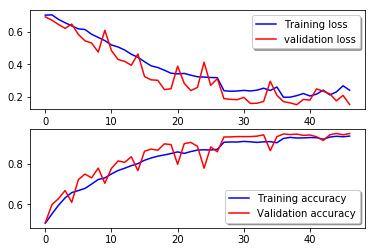

In [15]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [16]:
# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

100%|██████████| 12500/12500 [00:12<00:00, 1007.66it/s]


In [ ]:
#model.load_weights("./weights/weights.best.hdf5")

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(-1, IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [17]:
with open('submission_file_1.csv','w') as f:
    f.write('id,label\n')
            
with open('submission_file_1.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(-1, IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|██████████| 12500/12500 [01:17<00:00, 162.17it/s]


In [ ]:
data = test_data[0]
img_num = data[1]
img_data = data[0]
orig = img_data
data = img_data.reshape(-1, IMG_SIZE,IMG_SIZE,1)
model_out = model.predict([data])[0]

In [ ]:
model_out[0]